# Anomaly Detection

In this notebook, we will use multiple methods for anomaly detection.  We use multiple methods, since one method may find one group of anomalies and another method may find a different group.  Combining the results of mulitple anomaly detection methods leads to more robust anomaly detection.

**Steps**

1. Data Exploration
2. Anomaly Detection with H2O-3 Isolation Forest
3. Analyze anomalies
4. Anomaly Detection with H2O-3 Autoencoder
5. Compare and combine results

## Step 1: Data Exploration

Before we dive into the anomaly detection, let's initialize the h2o cluster and load our data in. We will be using public [Housing Dataset in King County](https://www.kaggle.com/harlfoxem/housesalesprediction). This contains one record per home for homes sold between May 2014 and May 2015 in King County.

In [1]:
# import h2o library and start h2o cluster
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpbraitjmw
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpbraitjmw/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpbraitjmw/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_megankurka_nvv3dq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
house_data = h2o.import_file("../../../../Data/KCHousing/kc_house_data.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
house_data.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7.1293e+09,20141013T000000,221900,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6.4141e+09,20141209T000000,538000,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
5.6315e+09,20150225T000000,180000,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2.4872e+09,20141209T000000,604000,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1.9544e+09,20150218T000000,510000,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
7.23755e+09,20140512T000000,1.225e+06,4,4.5,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1.3214e+09,20140627T000000,257500,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
2.008e+09,20150115T000000,291850,3,1.5,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
2.4146e+09,20150415T000000,229500,3,1,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
3.7935e+09,20150312T000000,323000,3,2.5,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### Visualize Data

We will first visualize the data to see if we can see anomalies in our data.

The histogram below shows us that must properties have between 2000 and 6000 sqft, however, there are some homes with 10k sqft and greater.

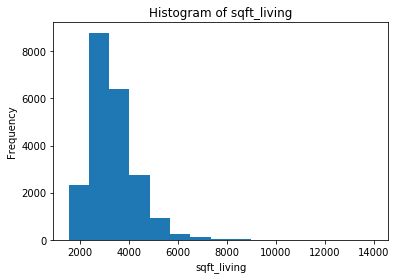

In [6]:
%matplotlib inline
house_data["sqft_living"].hist()

The histogram of year built shows that there was a big jump in construction between 2010 and 2015.

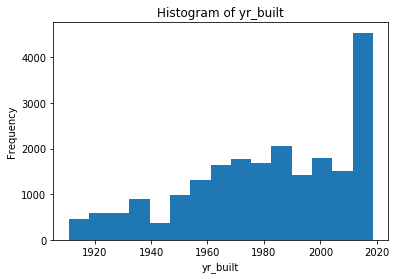

In [7]:
house_data["yr_built"].hist()

There may be cases where we which to visualize individual points, not aggregations. For most datasets, however, these scatter plots will have too many points causing the plot to be unreadable.

In this case, we can use H2O-3's Aggregator to reduce the size of the data. This method is preferred to random sampling because the aggregator will maintain the shape of the data. Random sampling will often cause outliers to be accidentally removed.

We will ask the aggregator to reduce the size of the data to 100 records.

In [8]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [24]:
from h2o.estimators.aggregator import H2OAggregatorEstimator


# Build an aggregated frame with around 100 records
agg = H2OAggregatorEstimator(target_num_exemplars = 100)
agg.train(training_frame=house_data)

# Use the aggregated model to create a new dataframe using aggregated_frame
plot_data = agg.aggregated_frame.as_data_frame(use_pandas = True)
plot_data["price"] = plot_data["price"]/1000

aggregator Model Build progress: |████████████████████████████████████████| 100%


We can now easily plot the data without being overwhelmed by points to see if there are any outliers in our graphs. The size of the marker indicates how many homes fall into that point.  

We can see that most homes have less than 4000 sqft and are less than 2 million.

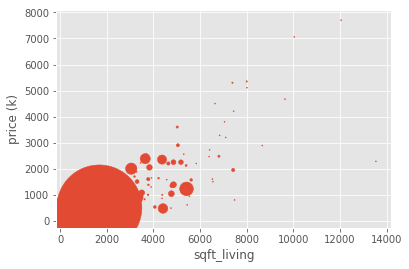

In [26]:
plt.scatter(plot_data.sqft_living, plot_data.price, s = plot_data.counts)
plt.xlabel("sqft_living")
plt.ylabel("price (k)")
plt.show()

The next graph shows the sqft of living area and the sqft of the lot.  We can see some outliers with a small living area and large lot and large living area and small lot.

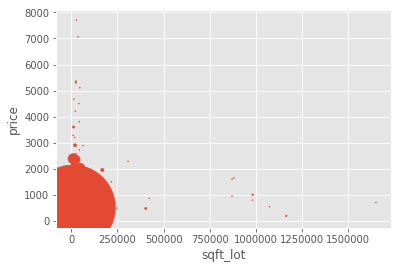

In [266]:
plt.scatter(plot_data.sqft_lot, plot_data.price, s = plot_data.counts)
plt.xlabel("sqft_lot")
plt.ylabel("price")
plt.show()

## Step 2: Anomaly Detection with Isolation Forest

The idea behind Isolation Forest is that anomalies are easier to separate from the rest of the data than other points. The Isolation Forest algorithm partitions the data through a forest of decision trees. Each split is made randomly. The number of splits it takes to isolate a record indicates whether or not the record is an anomaly. When a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies.

To find our anomalous houses, let's train our isolation forest and see how the predictions look. We will only use a subset of columns for demo purposes.

In [33]:
house_data.head()

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7.1293e+09,20141013T000000,221900,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6.4141e+09,20141209T000000,538000,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
5.6315e+09,20150225T000000,180000,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2.4872e+09,20141209T000000,604000,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1.9544e+09,20150218T000000,510000,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
7.23755e+09,20140512T000000,1.225e+06,4,4.5,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1.3214e+09,20140627T000000,257500,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
2.008e+09,20150115T000000,291850,3,1.5,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
2.4146e+09,20150415T000000,229500,3,1,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
3.7935e+09,20150312T000000,323000,3,2.5,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [38]:
from h2o.estimators import H2OIsolationForestEstimator

myX = [x for x in house_data.col_names if x not in ["id", "date"]]

isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", 
                                              max_depth = 20,
                                              seed = 1234 # make reproducible
                                             )
isolation_model.train(training_frame = house_data, x = myX)

isolationforest Model Build progress: |███████████████████████████████████| 100%


The predictions from the isolation forest return the mean_length. This is the average number of splits it took to isolate the record across all the decision trees in the forest. Records with a smaller mean_length are more likely to be anomalous since it takes fewer partitions of the data to isolate them.

In [39]:
predictions = isolation_model.predict(house_data)
predictions.head()

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.191489,12.86
0.356792,10.84
0.397709,10.34
0.410802,10.18
0.10311,13.94
0.728314,6.3
0.204583,12.7
0.225859,12.44
0.170213,13.12
0.14239,13.46


The histogram of the `mean_length` shows that it takes between 12 and 15 splits to separate the record.

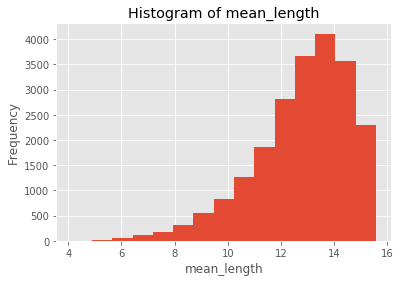

In [40]:
predictions["mean_length"].hist()

## Step 3: Analyze Anomalies

We will define an anomaly as a house who's mean_length is less than 5.0. These were houses who were easier to isolate from the rest of the data.

There are 57 anomalous houses.

In [48]:
anomalies = house_data[predictions["mean_length"] < 5.0]
print("Number of Anomalies: " + str(anomalies.nrow))

Number of Anomalies: 44


In [49]:
isolation_model.predict(anomalies)["mean_length"].cbind(anomalies[myX])

isolationforest prediction progress: |████████████████████████████████████| 100%


mean_length,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4.46,3.075e+06,4,5,4550,18641,1,1,4,3,10,2600,1950,2002,0,98074,47.6053,-122.077,4550,19508
4.18,2.125e+06,3,2.5,5403,24069,2,1,4,4,12,5403,0,1976,0,98166,47.4169,-122.348,3980,104374
4.82,3.07e+06,3,2.5,3930,55867,1,1,4,4,8,2330,1600,1957,0,98034,47.7022,-122.224,2730,26324
3.64,5.1108e+06,5,5.25,8010,45517,2,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
3.38,5.3e+06,6,6,7390,24829,2,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.21,4320,24619
4.66,2.2e+06,5,4.25,4640,22703,2,1,4,5,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
4.56,3.85e+06,4,4.25,5770,21300,2,1,4,4,11,5770,0,1980,0,98040,47.585,-122.222,4620,22748
4.14,3.278e+06,2,1.75,6840,10000,2.5,1,4,3,11,4350,2490,2001,0,98008,47.6042,-122.112,3120,12300
4.42,4.5e+06,5,5.5,6640,40014,2,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.28,3030,23408
4.76,3.6e+06,3,3.25,5020,12431,2,1,4,3,10,3420,1600,1941,2002,98144,47.5925,-122.287,3680,12620


### Interpreting Anomalies


Now that we have found anomalous employees, we are interested in why they are considered anomalies. To do this, we will train a surrogate decision tree. The purpose of the surrogate decision tree is to find records with the anomaly flag. To do this, it will find segments of similar anomalies and discover how to separate them from records that are not anomalies. We can use this decision tree to then describe anomalous segments of the data.

The steps of interpreting anomalies on a global level are:

1. Create a frame with a column that indicates whether the record was considered an anomaly.
2. Train a decision tree to predict the anomaly flag.
3. Visualize the decision tree to determine which segments of the data are considered anomalous.
4. In our first step, we will add a column called anomaly. This is a flag that indicates whether the isolation forest considered the record an anomaly.

In [50]:
house_data["anomaly_iso_for"] = (predictions["mean_length"] < 5).ifelse("Yes", "No")
house_data["anomaly_iso_for"].table()

anomaly_iso_for,Count
No,21569
Yes,44


Now that we have the surrogate data, we can train a single decision tree to predict the anomaly flag. We will keep this decision tree simple (only a single decision tree with a depth of 5) because the purpose of the decision tree is to be completely interpretable.

In [182]:
from h2o.estimators import H2ORandomForestEstimator

global_surrogate_dt = H2ORandomForestEstimator(model_id = "global_surrogate_decision_tree.hex", 
                                               ntrees = 1, max_depth = 5, min_rows = 10,
                                               sample_rate = 1, mtries = len(myX))
global_surrogate_dt.train(training_frame = house_data, x = myX, y = "anomaly_iso_for")

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [183]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(decision_tree, image_file_path):
    # Download MOJO
    mojo_path = decision_tree.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree 0 -i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    
    return Image(image_file_path)

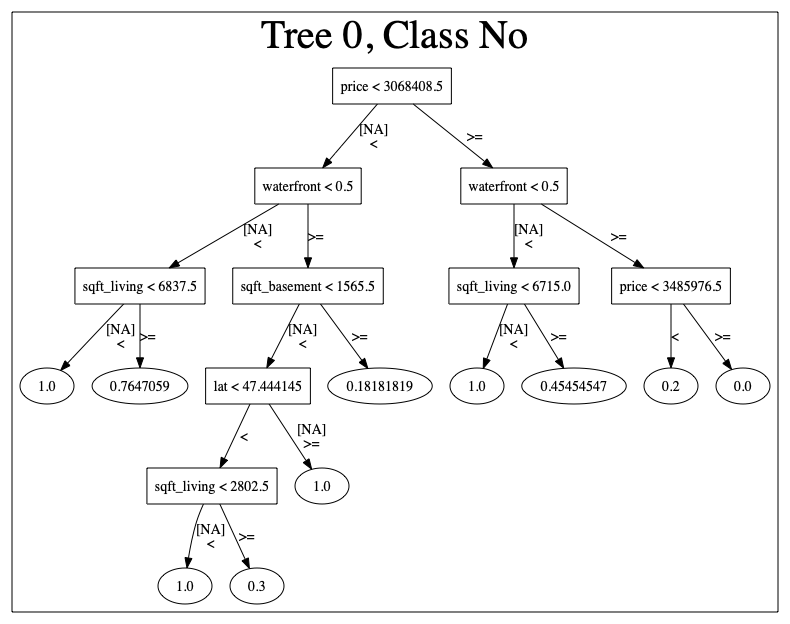

In [184]:
generateTreeImage(global_surrogate_dt, "./global_surrogate_decision_tree.png")


The visualization shows our global surrogate decision tree. The values in the leaf nodes represent the probability of the record not being an anomaly. We are, therefore, interested in leaf nodes with low values - these will indicate a segment of data that is anomalous.

We can see that there are three leaf nodes with high proportion of anomalies.  The leaf nodes show the following groups:

1. Large Homes with Lower Price
    * sqft_basement >= 1,565
    * waterfront == 1
    * price < 3 million
2. Expensive Homes on the Water
    * price > 3 million
    * waterfront == 1
    * (this segment encompasses the two leaf nodes to the right of the decision tree)
    
**Segment 1**

If we examine Segment 1, we can see that houses of that size on the waterfront are typically more expensive.

In [187]:
segment_1 = house_data[(house_data["price"] < 3068408) &
                       (house_data["waterfront"] == 1) &
                       (house_data["sqft_basement"] >= 1565)]
print("# of houses in Segment 1: {}".format(segment_1.nrow))

# of houses in Segment 1: 11


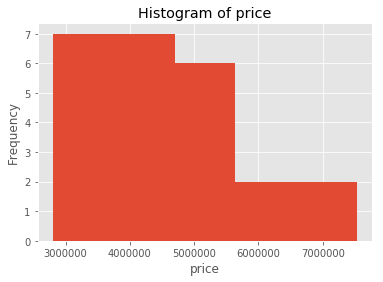

In [191]:
house_data[(house_data["waterfront"]== 1) & (house_data["sqft_basement"] >= 1565)]["price"].hist()

**Segment 2**

This segment are considered outliers because they are on the waterfront and are much more expensive than a typical home in the dataset.

In [193]:
segment_2 = house_data[(house_data["price"] >= 3068408) &
                       (house_data["waterfront"] == 0)]
print("# of houses in Segment 2: {}".format(segment_2.nrow))

# of houses in Segment 2: 24


In [197]:
house_data["waterfront"].table()

waterfront,Count
0,21450
1,163


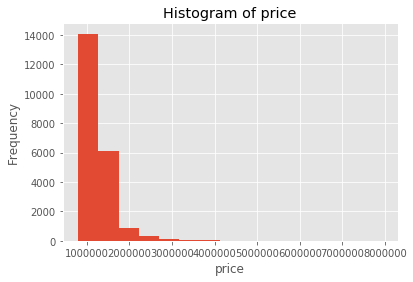

In [195]:
house_data["price"].hist()

## Step 4: Anomaly Detection with Autoencoder

The idea behind Autoencoder is that if we use deep learning to build a low dimensional representation of the data then this approximation of the data will have high error for anomalies.

Note: There are many parameters that can be set for a Deep Learning model (Deep Learning is the algorithm used for Autoencoder). We want a model that is good at reconstructing the data so we want to learn the best parameters for this dataset.  If our Autoencoder model is not good at reconstructing any rows of data, then it will not be good at helping us find outliers.

To start, we will first run a grid search to determine the optimal Autoencoder parameters on some holdout set.

In [198]:
train, test = house_data.split_frame(ratios = [0.75], destination_frames=["train", "test"], seed = 1234)

In [199]:
## Set DeepLearning Grid Search Parameters
from h2o.estimators import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
dl_hyper_params_tune = {
    'activation' : ["Tanh","RectifierWithDropout","TanhWithDropout"],
    'hidden': [[2], [5], [10], [2, 2]],
    'input_dropout_ratio' : [0,0.05],
    'l1': [0, 1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 1e-04],
    'l2': [0, 1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 1e-04]}

In [200]:
random_search_criteria_tune = {'strategy': "RandomDiscrete",
                               'max_runtime_secs': 60, 
                               'seed' : 1234, # make it reproducible
                               'stopping_rounds' : 5, # stop grid search once the best models have similar AUC
                               'stopping_metric' : "MSE",
                               'stopping_tolerance': 1e-3
                              }

In [201]:
stopping_metric = "MSE"
stopping_tolerance = 1e-3
stopping_rounds = 5

In [203]:
## Deep Learning Model

dl_model = H2ODeepLearningEstimator(
    seed = 1234,
    ## here, use "more than enough" epochs - we have early stopping
    epochs=10000, 
    ## early stopping
    stopping_rounds = stopping_rounds,
    stopping_metric = stopping_metric,
    stopping_tolerance = stopping_tolerance,
    autoencoder = True,
    reproducible = True
)

In [204]:
## Run Deep Learning Grid Search
dl_grid = H2OGridSearch(dl_model, hyper_params = dl_hyper_params_tune,
                        grid_id = 'ae_grid',
                        search_criteria = random_search_criteria_tune)

dl_grid.train(x=myX, 
              ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
              max_runtime_secs = 3600, 
              training_frame = train,
              validation_frame = test
             )

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [2]
Hyper-parameter: input_dropout_ratio, 0.05
Hyper-parameter: l1, 0.0001
Hyper-parameter: l2, 8e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [2]
Hyper-parameter: input_dropout_ratio, 0.0
Hyper-parameter: l1, 4e-05
Hyper-parameter: l2, 3e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [10]
Hyper-parameter: input_dropout_ratio, 0.0
Hyper-parameter: l1, 8e-05
Hyper-parameter: l2, 8e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lea


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [10]
Hyper-parameter: input_dropout_ratio, 0.05
Hyper-parameter: l1, 5e-05
Hyper-parameter: l2, 9e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or le


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [5]
Hyper-parameter: input_dropout_ratio, 0.05
Hyper-parameter: l1, 4e-05
Hyper-parameter: l2, 0.0
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead 


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [10]
Hyper-parameter: input_dropout_ratio, 0.0
Hyper-parameter: l1, 2e-05
Hyper-parameter: l2, 0.0001
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or le


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [10]
Hyper-parameter: input_dropout_ratio, 0.0
Hyper-parameter: l1, 9e-05
Hyper-parameter: l2, 2e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lea


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [5]
Hyper-parameter: input_dropout_ratio, 0.0
Hyper-parameter: l1, 4e-05
Hyper-parameter: l2, 8e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [2]
Hyper-parameter: input_dropout_ratio, 0.05
Hyper-parameter: l1, 0.0
Hyper-parameter: l2, 3e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead 


Hyper-parameter: activation, RectifierWithDropout
Hyper-parameter: hidden, [2]
Hyper-parameter: input_dropout_ratio, 0.05
Hyper-parameter: l1, 9e-05
Hyper-parameter: l2, 8e-05
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lea

In [206]:
dl_grid.get_grid("mse")

                 activation  hidden input_dropout_ratio      l1      l2  \
0                      Tanh    [10]                 0.0  5.0E-5  9.0E-5   
1                      Tanh    [10]                0.05  1.0E-5     0.0   
2                      Tanh    [10]                0.05  2.0E-5  6.0E-5   
3                      Tanh    [10]                0.05  2.0E-5  1.0E-4   
4                      Tanh    [10]                0.05  6.0E-5     0.0   
5                      Tanh    [10]                0.05  6.0E-5  3.0E-5   
6                      Tanh     [5]                 0.0  7.0E-5  5.0E-5   
7                      Tanh     [5]                 0.0  7.0E-5  7.0E-5   
8                      Tanh     [5]                 0.0  9.0E-5  8.0E-5   
9                      Tanh     [5]                0.05  6.0E-5  3.0E-5   
10                     Tanh     [5]                0.05  5.0E-5  1.0E-4   
11                     Tanh     [5]                0.05  1.0E-4  2.0E-5   
12          TanhWithDropo

In [207]:
ae_model = h2o.get_model("ae_grid_model_61")

Most of our houses have a reconstruction error less than 0.1. We see a small peak of houses with reconstruction error scores between 0.04 and 0.05.  

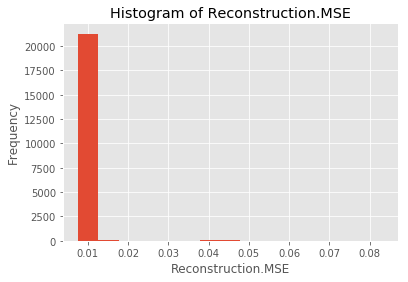

In [208]:
reconstruction_error = ae_model.anomaly(house_data)
reconstruction_error.hist()

We will define an anomaly as a house who's reconstruction error is greater than 0.038. These were houses where the autoencoder had a hard time reconstructing.

There are 41 anomalous houses.

In [212]:
anomalies_ae = house_data[reconstruction_error["Reconstruction.MSE"] > 0.038]
print("Number of Anomalies: " + str(anomalies_ae.nrow))

Number of Anomalies: 41


In [213]:
house_data["anomaly_ae"] = (reconstruction_error["Reconstruction.MSE"] > 0.038).ifelse("Yes", "No")

We will use the same surrogate model approach to determine what segments of anomalies the Autoencoder found.

In [232]:
global_surrogate_dt_ae = H2ORandomForestEstimator(model_id = "global_surrogate_decision_tree_ae.hex", 
                                                  ntrees = 1, max_depth = 5, min_rows = 10, 
                                                  sample_rate = 1, mtries = len(myX))
global_surrogate_dt_ae.train(training_frame = house_data, x = myX, y = "anomaly_ae")

drf Model Build progress: |███████████████████████████████████████████████| 100%


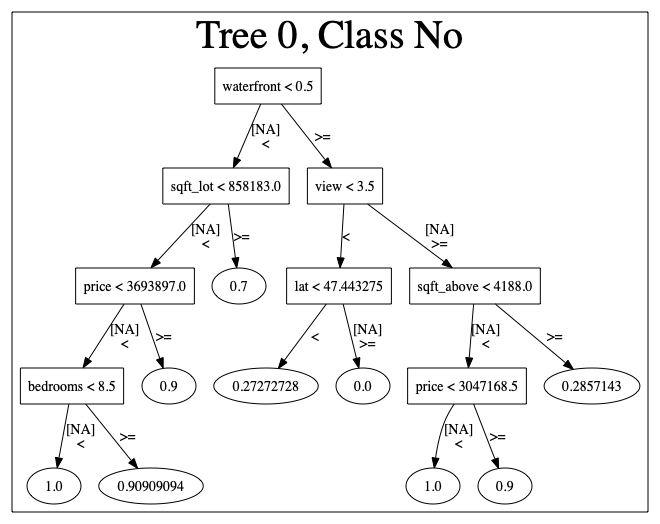

In [233]:
generateTreeImage(global_surrogate_dt_ae, "./global_surrogate_decision_tree_ae.png")


The visualization shows our global surrogate decision tree. The values in the leaf nodes represent the probability of the record not being an anomaly. We are, therefore, interested in leaf nodes with low values - these will indicate a segment of data that is anomalous.

We can see that there are two leaf nodes with high proportion of anomalies.  The leaf nodes show the following groups:

1. Waterfront Homes with a Low View Score
    * waterfront == 1
    * view < 3.5
2. Very Large Homes on Waterfront
    * waterfront == 1
    * view >= 3.5
    * sqft_above >= 4,188
    
    
**Segment 1**

For waterfront homes, the view score is almost always 4 (the highest view score). These houses are strange that they are on the waterfront but do not have a view.

In [219]:
segment_1 = house_data[(house_data["waterfront"] == 1) &
                       (house_data["view"] < 3.5)]
print("# of houses in Segment 1: {}".format(segment_1.nrow))

# of houses in Segment 1: 28


In [221]:
house_data[house_data["waterfront"] == 1]["view"].table()

view,Count
1,1
2,8
3,19
4,135


**Segment 2**

These houses are on the water and larger than a typical house.

In [227]:
segment_2 = house_data[(house_data["waterfront"] == 1) &
                       (house_data["view"] >= 3.5) &
                       (house_data["sqft_above"] >= 4188)]
print("# of houses in Segment 2: {}".format(segment_2.nrow))

# of houses in Segment 2: 14


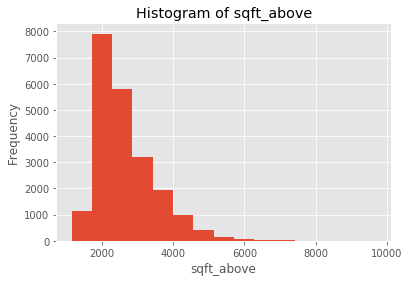

In [234]:
house_data["sqft_above"].hist()

## Step 5: Compare and Combine Results

We have identified anomalies in two different ways.  We can now see which homes were identified as outliers by both methods are by one.

If we compare the results from the two methods, we can see that about 20% of homes were found to be anomalous by both.  

In [214]:
house_data[["anomaly_iso_for", "anomaly_ae"]].table()

anomaly_iso_for,anomaly_ae,Counts
No,No,21541
No,Yes,28
Yes,No,31
Yes,Yes,13


The homes that were identified by both methods as anomalous are generally larger and more expensive homes.  They are also all on the waterfront except 1.

In [250]:
anomalous_both = house_data[(house_data["anomaly_ae"] == "Yes") & (house_data["anomaly_iso_for"] == "Yes")]
anomalous_both.head(13)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,anomaly_iso_for,anomaly_ae
1.2476e+09,20141020T000000,5.1108e+06,5,5.25,8010,45517,2,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788,Yes,Yes
7.5587e+09,20150413T000000,5.3e+06,6,6,7390,24829,2,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.21,4320,24619,Yes,Yes
8.1061e+09,20141114T000000,3.85e+06,4,4.25,5770,21300,2,1,4,4,11,5770,0,1980,0,98040,47.585,-122.222,4620,22748,Yes,Yes
7.5249e+09,20141210T000000,3.278e+06,2,1.75,6840,10000,2.5,1,4,3,11,4350,2490,2001,0,98008,47.6042,-122.112,3120,12300,Yes,Yes
7.7385e+09,20140815T000000,4.5e+06,5,5.5,6640,40014,2,1,4,3,12,6350,290,2004,0,98155,47.7493,-122.28,3030,23408,Yes,Yes
2.32203e+09,20141119T000000,999000,3,2.75,2830,505166,1,1,3,4,8,1830,1000,1962,0,98070,47.3782,-122.514,2120,21988,Yes,Yes
9.8087e+09,20140611T000000,7.0625e+06,5,4.5,10040,37325,2,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,Yes,Yes
6.7627e+09,20141013T000000,7.7e+06,6,8,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,Yes,Yes
1.92406e+09,20140617T000000,4.668e+06,5,6.75,9640,13068,1,1,4,3,12,4820,4820,1983,2009,98040,47.557,-122.21,3270,10454,Yes,Yes
1.21039e+08,20150313T000000,425000,3,2.75,3610,107386,1.5,1,3,3,8,3130,480,1918,1962,98023,47.3351,-122.362,2630,42126,Yes,Yes


This is the most inexpensive home in our anomalies list.  Looking closely at it, we can see that it is an anomaly because while it's price, # of bedrooms, and # of bathrooms fall within normal range, it is abnormal because of it's huge lot size and waterfront placement.

In [252]:
anomalous_both[anomalous_both["price"] == anomalous_both["price"].min()]

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,anomaly_iso_for,anomaly_ae
1.21039e+08,20150313T000000,425000,3,2.75,3610,107386,1.5,1,3,3,8,3130,480,1918,1962,98023,47.3351,-122.362,2630,42126,Yes,Yes


Looking back at our graph from earlier, we can see this home showing as one of the outliers on the lower right corner of the chart.

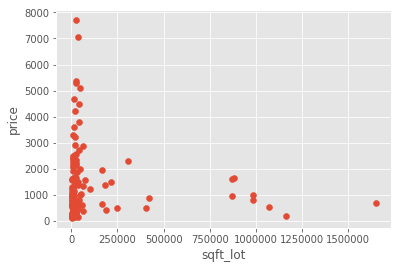

In [268]:
plt.scatter(plot_data.sqft_lot, plot_data.price)
plt.xlabel("sqft_lot")
plt.ylabel("price")
plt.show()

In [269]:
h2o.cluster().shutdown()

H2O session _sid_a451 closed.
